In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import os

#Merging all the months data into a single csv file
files = [file for file in os.listdir('./Sales_Data')]
df = pd.DataFrame()

# Iterate over each CSV file and append its data
for csv_file in files:
    file_path = os.path.join('./Sales_Data', csv_file)
    data = pd.read_csv(file_path)
    df = pd.concat([df, data])

df.to_csv('year_data.csv', index=False)


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x95 in position 1095: invalid start byte

In [ ]:
df = pd.read_csv('year_data.csv')

Data Cleaning


In [2]:
df_copy = df.copy()
df_copy = df_copy.dropna()
df_copy = df_copy[df_copy['Order Date'].str[0:2] != 'Or']
df_copy['Order Date'] = pd.to_datetime(df_copy['Order Date'], format="%m/%d/%y %H:%M")
df_copy['Price Each'] = df_copy['Price Each'].astype(float)
df_copy['Quantity Ordered'] = df_copy['Quantity Ordered'].astype(int)

Total Sales Per Month

In [8]:
df_copy['Month'] = df_copy['Order Date'].dt.month
df_copy['Total Price'] = df_copy['Price Each'] * df_copy['Quantity Ordered']

In [18]:
df_monthly_sales = pd.DataFrame(df_copy.groupby('Month')['Total Price'].sum()).reset_index()

In [20]:
df_monthly_sales['Month'] = df_monthly_sales['Month'].apply(lambda x: calendar.month_abbr[x])
df_monthly_sales.set_index('Month', inplace=True)

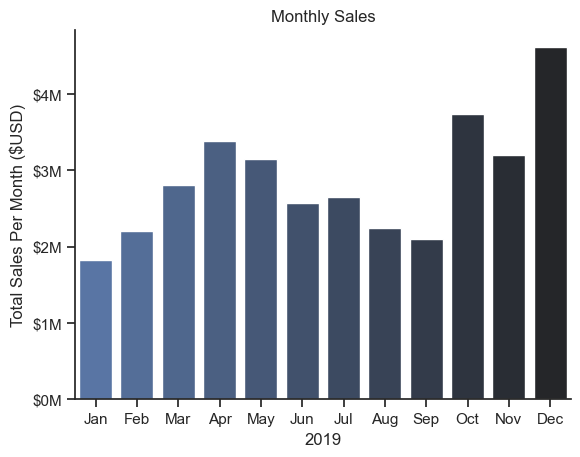

In [49]:
sns.set_theme(style="ticks")
sns.barplot(data=df_monthly_sales, x='Month', y='Total Price', hue='Month', palette='dark:b_r')
plt.title('Monthly Sales')
plt.xlabel('2019')
plt.ylabel('Total Sales Per Month ($USD)')
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f'${int(x/1000000)}M'))
sns.despine()
plt.show()

Yearly Sales Per City 

In [65]:
def get_city(address):
    return address.split(',')[1]
def get_state(address):
    return address.split(',')[2].split(' ')[1]

df_copy['City'] = df_copy['Purchase Address'].apply(lambda x: f'{get_city(x)} [{get_state(x)}]')

In [66]:
df_city_sales = pd.DataFrame(df_copy.groupby('City')['Total Price'].sum().sort_values(ascending=False)).reset_index()

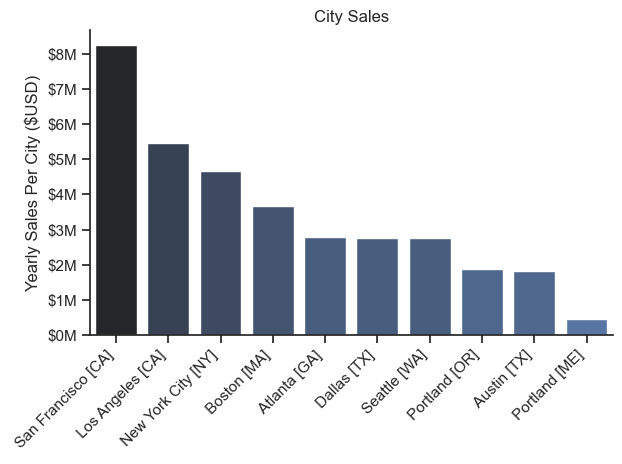

In [67]:
sns.barplot(data=df_city_sales, x='City', y='Total Price', hue='Total Price', palette='dark:b_r', legend=False)
plt.title('City Sales')
plt.xlabel('')
plt.ylabel('Yearly Sales Per City ($USD)')
plt.xticks(rotation=45, ha='right')
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f'${int(x/1000000)}M'))
sns.despine()
plt.tight_layout()
plt.show()

What is the best time to advertise for any product ? 

In [71]:
df_copy['Hour'] = df_copy['Order Date'].dt.hour

In [73]:
df_hourly_purchase = pd.DataFrame(df_copy.groupby('Hour').count())

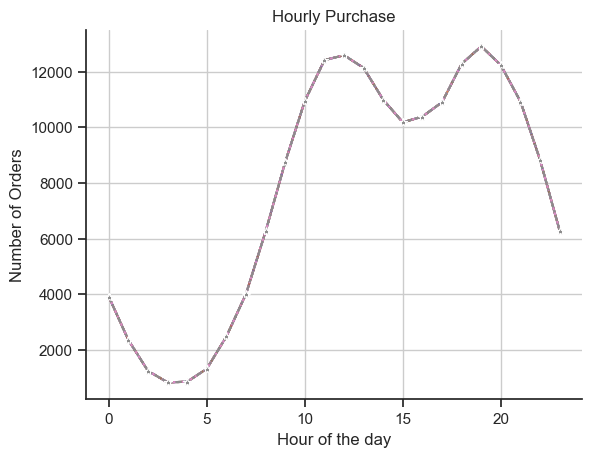

In [98]:
sns.lineplot(data=df_hourly_purchase, marker='*', legend=False)
plt.xlabel('Hour of the day')
plt.grid()
plt.ylabel('Number of Orders')
plt.title('Hourly Purchase')
sns.despine()
plt.show()

What products are bought together ?

In [102]:
df_copy.reset_index(inplace=True)

In [122]:
df_duplicate = df_copy[df_copy.duplicated(subset='Order ID', keep=False)]

In [125]:
df_duplicate.loc[:, 'All_products'] = df_duplicate.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))

In [128]:
df_duplicate = df_duplicate.drop_duplicates(subset='Order ID')

In [138]:
from itertools import combinations
from collections import Counter

pair_counts = Counter()

for row in df_duplicate['All_products']:
    row_list = row.split(',')
    pair_counts.update(Counter(combinations(row_list, 2)))

pair_counts


Counter({('iPhone', 'Lightning Charging Cable'): 1005,
         ('Google Phone', 'USB-C Charging Cable'): 987,
         ('iPhone', 'Wired Headphones'): 447,
         ('Google Phone', 'Wired Headphones'): 414,
         ('Vareebadd Phone', 'USB-C Charging Cable'): 361,
         ('iPhone', 'Apple Airpods Headphones'): 360,
         ('Google Phone', 'Bose SoundSport Headphones'): 220,
         ('USB-C Charging Cable', 'Wired Headphones'): 160,
         ('Vareebadd Phone', 'Wired Headphones'): 143,
         ('Lightning Charging Cable', 'Wired Headphones'): 92,
         ('Lightning Charging Cable', 'Apple Airpods Headphones'): 81,
         ('Vareebadd Phone', 'Bose SoundSport Headphones'): 80,
         ('USB-C Charging Cable', 'Bose SoundSport Headphones'): 77,
         ('Apple Airpods Headphones', 'Wired Headphones'): 69,
         ('Lightning Charging Cable', 'USB-C Charging Cable'): 58,
         ('Lightning Charging Cable', 'AA Batteries (4-pack)'): 55,
         ('Lightning Charging Cable'

In [150]:
type(pair_counts)

collections.Counter

In [151]:
df_pair_counts = pd.DataFrame.from_dict(pair_counts, orient='index', columns=['Count']).reset_index()
df_pair_counts.rename(columns={'index': 'Pairs'}, inplace=True)

In [157]:
df_pair_counts.sort_values(by='Count', ascending=False, inplace=True)

In [168]:
df_pair_counts = df_pair_counts.head(10)
df_pair_counts['Pairs'] = df_pair_counts['Pairs'].apply(lambda x: str(x))

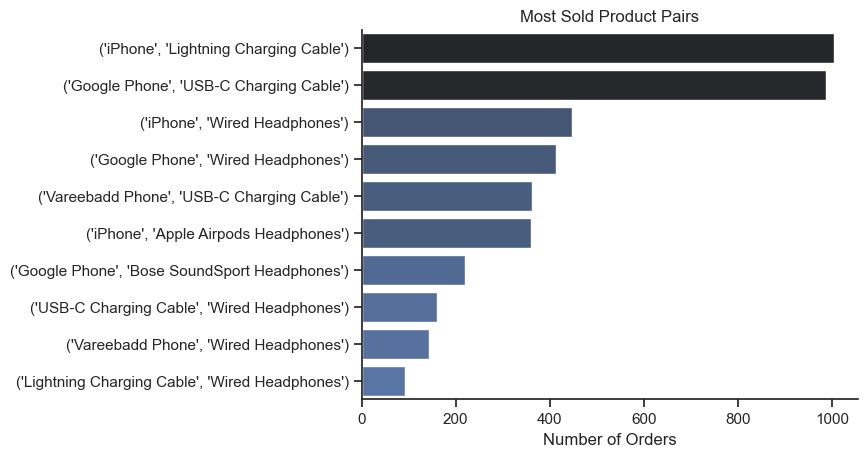

In [184]:
sns.barplot(data=df_pair_counts, x='Count', y='Pairs', hue='Count', palette='dark:b_r', legend=False)
plt.title('Most Sold Product Pairs')
plt.xlabel('Number of Orders')
plt.ylabel('')
sns.despine()
plt.show()
